In [1]:
import pygad
import pygad.cnn
import pygad.gacnn
import pygad.torchga

import torch
import torch.fft
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm import tqdm
from einops.layers.torch import Reduce

from sklearn.metrics import balanced_accuracy_score
from torchmetrics.classification import Accuracy
import matplotlib.pyplot  as plt 

import numpy as np
import pipe  as pp
import time
import cv2 as cv
import glob
import os

import auto_labeling.guided as alg
sample_shape = (512,512,3)

import math

In [2]:
import torch.nn as nn
import torch.nn.functional as F


class Morphology(nn.Module):
    '''
    Base class for morpholigical operators 
    For now, only supports stride=1, dilation=1, kernel_size H==W, and padding='same'.
    '''
    def __init__(self, in_channels, out_channels, kernel_size=5, soft_max=True, beta=15, type=None):
        '''
        in_channels: scalar
        out_channels: scalar, the number of the morphological neure. 
        kernel_size: scalar, the spatial size of the morphological neure.
        soft_max: bool, using the soft max rather the torch.max(), ref: Dense Morphological Networks: An Universal Function Approximator (Mondal et al. (2019)).
        beta: scalar, used by soft_max.
        type: str, dilation2d or erosion2d.
        '''
        super(Morphology, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.soft_max = soft_max
        self.beta = beta
        self.type = type

        self.weight = nn.Parameter(torch.zeros(out_channels, in_channels, kernel_size, kernel_size), requires_grad=True)
        self.unfold = nn.Unfold(kernel_size, dilation=1, padding=0, stride=1)

    def forward(self, x):
        '''
        x: tensor of shape (B,C,H,W)
        '''
        # padding
        x = fixed_padding(x, self.kernel_size, dilation=1)
        
        # unfold
        x = self.unfold(x)  # (B, Cin*kH*kW, L), where L is the numbers of patches
        x = x.unsqueeze(1)  # (B, 1, Cin*kH*kW, L)
        L = x.size(-1)
        L_sqrt = int(math.sqrt(L))

        # erosion
        weight = self.weight.view(self.out_channels, -1) # (Cout, Cin*kH*kW)
        weight = weight.unsqueeze(0).unsqueeze(-1)  # (1, Cout, Cin*kH*kW, 1)

        if self.type == 'erosion2d':
            x = weight - x # (B, Cout, Cin*kH*kW, L)
        elif self.type == 'dilation2d':
            x = weight + x # (B, Cout, Cin*kH*kW, L)
        else:
            raise ValueError
        
        if not self.soft_max:
            x, _ = torch.max(x, dim=2, keepdim=False) # (B, Cout, L)
        else:
            x = torch.logsumexp(x*self.beta, dim=2, keepdim=False) / self.beta # (B, Cout, L)

        if self.type == 'erosion2d':
            x = -1 * x

        # instead of fold, we use view to avoid copy
        x = x.view(-1, self.out_channels, L_sqrt, L_sqrt)  # (B, Cout, L/2, L/2)

        return x 

class Dilation2d(Morphology):
    def __init__(self, in_channels, out_channels, kernel_size=5, soft_max=True, beta=20):
        super(Dilation2d, self).__init__(in_channels, out_channels, kernel_size, soft_max, beta, 'dilation2d')

class Erosion2d(Morphology):
    def __init__(self, in_channels, out_channels, kernel_size=5, soft_max=True, beta=20):
        super(Erosion2d, self).__init__(in_channels, out_channels, kernel_size, soft_max, beta, 'erosion2d')



def fixed_padding(inputs, kernel_size, dilation):
    kernel_size_effective = kernel_size + (kernel_size - 1) * (dilation - 1)
    pad_total = kernel_size_effective - 1
    pad_beg = pad_total // 2
    pad_end = pad_total - pad_beg
    padded_inputs = F.pad(inputs, (pad_beg, pad_end, pad_beg, pad_end))
    return padded_inputs

In [3]:
# custom max pooling along "planes"
class ChannelMaxPool(torch.nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, input):
        ch = 1
        if(len(input.shape) <= 3): 
            ch = 0
        res, _ = torch.max(input, ch, keepdim=True)
        return res
    
# custom min pooling along "planes"
class ChannelMinPool(torch.nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, input):
        ch = 1
        if(len(input.shape) <= 3): 
            ch = 0
        res, _ = torch.min(input, ch, keepdim=True)
        return res

class BiasLayer(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        bias_value = torch.randn((1))
        self.bias_layer = torch.nn.Parameter(bias_value)
    
    def forward(self, x):
        return x + self.bias_layer

In [246]:
# Build the PyTorch model.
pst_layer   = PST2D(in_channels=sample_shape[2], out_channels=15)
batch_norm  = torch.nn.BatchNorm2d(num_features=15)
input_layer = torch.nn.Conv2d(in_channels=15, out_channels=40, kernel_size=7, stride=2)
relu_layer1 = torch.nn.ReLU()
max_pool1   = torch.nn.MaxPool2d(kernel_size=5, stride=1)


conv_layer2 = torch.nn.Conv2d(in_channels=40, out_channels=20, kernel_size=7, stride=1)
relu_layer2 = torch.nn.ReLU()
max_pool2   = torch.nn.MaxPool2d(kernel_size=3, stride=1)

conv_layer3 = torch.nn.Conv2d(in_channels=20, out_channels=30, kernel_size=7, stride=1)
relu_layer3 = torch.nn.ReLU()
max_pool3   = torch.nn.MaxPool2d(kernel_size=3, stride=1)

#conv_layer4 = torch.nn.Conv2d(in_channels=15, out_channels=3, kernel_size=3)
#relu_layer4 = torch.nn.ReLU()
#max_pool4   = torch.nn.MaxPool2d(kernel_size=3, stride=1)

deconv_layer5 = torch.nn.ConvTranspose2d(in_channels=30, out_channels=15, kernel_size=11, stride=1)
relu_layer5 = torch.nn.ReLU()

deconv_layer6 = torch.nn.ConvTranspose2d(in_channels=15, out_channels=10, kernel_size=7, stride=1)
relu_layer6 = torch.nn.ReLU()

deconv_layer7 = torch.nn.ConvTranspose2d(in_channels=10, out_channels=10, kernel_size=5, stride=1)
relu_layer7 = torch.nn.ReLU()

deconv_layer8 = torch.nn.ConvTranspose2d(in_channels=10, out_channels=2, kernel_size=8, stride=1)
relu_layer8 = torch.nn.ReLU()


bias_layer = BiasLayer()
sigmoid_layer1 = torch.nn.Sigmoid()

model = torch.nn.Sequential(pst_layer,
                            batch_norm,
                            input_layer,
                            relu_layer1,
                            max_pool1,

                            conv_layer2,
                            relu_layer2,
                            max_pool2,

                            conv_layer3,
                            relu_layer3,
                            max_pool3,

                            #conv_layer4,
                            #relu_layer4,
                            #max_pool4,

                            deconv_layer5,
                            relu_layer5,
#
                            deconv_layer6,
                            relu_layer6,
#
                            deconv_layer7,
                            relu_layer7,

                            deconv_layer8,
                            relu_layer8,

                            bias_layer,
                            sigmoid_layer1,

                            )

In [4]:
# custom pst layer
# only batch mode! (b_idx, channel, h, w)
class PST2D(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(PST2D, self).__init__()
        if out_channels % in_channels != 0:
            raise ValueError('out_channels must be divisible by in_channels')
        self.warp_parameters  = torch.nn.Parameter(500*torch.randn(size=(out_channels, 1, 1)
                                                              ), requires_grad=True)
        self.phase_parameters = torch.nn.Parameter(500*torch.randn(size=(out_channels, 1, 1)
                                                              ), requires_grad=True)
        self.spatial_dim = [None, None]
        self.in_channels  = in_channels
        self.out_channels = out_channels
        self._RHO = torch.Tensor(0)
        self.register_buffer('_RHO_const', self._RHO)
    
    def _init_pst(self, h, w):
        def c2p(x, y):
            theta = torch.atan2(y, x)
            rho = torch.hypot(x, y)
            return (theta, rho)
        # set the frequency grid
        u = torch.linspace(-0.5, 0.5, h, device=self.warp_parameters.device).float()
        v = torch.linspace(-0.5, 0.5, w, device=self.warp_parameters.device).float()
        [U, V] = torch.meshgrid(u, v, indexing="ij")
        [_THETA, _RHO] = c2p(U, V)
        self._RHO = _RHO.unsqueeze(0)
        self.register_buffer('_RHO_const', self._RHO)
    
    def forward(self, x):
        if list(x.shape[-2:]) != list(self.spatial_dim):
            self._init_pst(x.shape[-2], x.shape[-1])
            self.spatial_dim = list(x.shape[-2:])
        # construct the PST Kernel
        _W = torch.relu(self.warp_parameters) + 1
        _S = torch.relu(self.phase_parameters) + 1
        pst_kernels = _W * self._RHO * torch.arctan(_W * self._RHO) - 0.5 * torch.log(
            1 + (_W * self._RHO) ** 2
        )
        pst_kernels = _S * pst_kernels
        x   = torch.fft.fft2(x)
        sft = torch.fft.fftshift(torch.exp(-1j * pst_kernels))
        res = []
        per_channel = self.out_channels//self.in_channels
        for c in range(x.shape[1]):
            xs = x[:, c:(c+1), :, :]
            xs = xs.expand(-1, per_channel, -1, -1)
            # apply the pst kernel
            xs = torch.fft.ifft2(
                xs * sft[(per_channel*c):(per_channel*(c + 1))]
            )
            res.append(xs)
        x = torch.cat(res, dim=1)
        #x = torch.cat([
        #    torch.angle(x),
        #    torch.abs(x)
        #], dim=1)
        return torch.angle(x)

    def extra_repr(self):
        return f"in_channels={self.in_channels}, out_channels={self.out_channels}"

In [266]:
class CDModel(torch.nn.Module):
    def __init__(self, n_branches, height, width):
        super(CDModel, self).__init__()

        pst_layer   = PST2D(in_channels=sample_shape[2], out_channels=9)
        inst_norm   = torch.nn.InstanceNorm2d(num_features=9*1+3)
        batch_norm  = torch.nn.BatchNorm2d(9*1+3, affine=False, track_running_stats=False)
        input_layer = torch.nn.Conv2d(in_channels=9*1+3, out_channels=11, kernel_size=17)
        relu_layer1 = torch.nn.ReLU()
        max_pool1   = torch.nn.MaxPool2d(kernel_size=3, stride=1)
        iconv_layer = torch.nn.Conv2d(in_channels=11, out_channels=9, kernel_size=11)
        relu_layer2 = torch.nn.ReLU()
        #sigmoid     = torch.nn.Sigmoid()

        self.head = [pst_layer,
                     inst_norm,
                     batch_norm, 
                     input_layer, 
                     relu_layer1, 
                     max_pool1, 
                     iconv_layer, 
                     relu_layer2,
                     #sigmoid,
                     ]

        cd_pattern = [(9, 7), (9, 7), (9, 7), (3, 7), (3, 7), (1, 3)]
        self.branches = list()
        for bi in range(0, n_branches):
            content = list()
            content.append(
                    self.gen_CD_block(cd_pattern*(bi+1))
                )
            content[-1].append(torch.nn.ReLU())
            self.branches.append(content)
        
        tconv1     = torch.nn.Conv2d(in_channels=n_branches*cd_pattern[0][0], out_channels=20, kernel_size=7)
        tsigmoid1  = torch.nn.ReLU()
        tmaxpool1  = torch.nn.MaxPool2d(kernel_size=5, stride=1)
        tconv2     = torch.nn.Conv2d(in_channels=20, out_channels=9, kernel_size=7)
        tsigmoid2  = torch.nn.ReLU()
        tmaxpool2  = torch.nn.MaxPool2d(kernel_size=5, stride=1)
        tconv3     = torch.nn.Conv2d(in_channels=9, out_channels=2, kernel_size=7)
        tsigmoid3  = torch.nn.ReLU()
        tbias      = BiasLayer()
        tsigmoid_o = torch.nn.Sigmoid()

        self.tail = [tconv1, 
                     tsigmoid1,
                     tmaxpool1,
                     tconv2, 
                     tsigmoid2,
                     tmaxpool2,
                     tconv3, 
                     tsigmoid3,
                     tbias,
                     tsigmoid_o
                     ]

        self._publish_layers()
    
    def _publish_layers(self):
        for i, l in enumerate(self.head):
            setattr(self, f'head_{i}', l)
        for i, l in enumerate(self.tail):
            setattr(self, f'tail_{i}', l)
        for i, br in enumerate(self.branches):
            for j, blk in enumerate(br):
                for k, l in enumerate(blk):
                    setattr(self, f'branch_{i}_b{j}_l{k}', l)   

    def forward(self, x):
        def shape_aware_sum(xx, yy):
            if xx.shape == yy.shape:
                return xx + yy
            _pad = ((xx.shape[-2]-yy.shape[-2])//2, 
                    (xx.shape[-1]-yy.shape[-1])//2)
            xx = xx[:,:,_pad[0]:-_pad[0], _pad[1]:-_pad[1]]
            return xx + yy
        
        pst = self.head[0](x)
        x = torch.cat([pst, x], dim=1)
        for l in self.head[1:]:
            x = l(x)
        b_sigm = list()
        b = list()
        for i, lb in enumerate(self.branches):
            xb = x
            if len(b_sigm) > 0:
                xb = shape_aware_sum(xb, -b_sigm[i-1])

            blk_out = list()
            for i, block in enumerate(lb):
                if len(blk_out) > 0:
                    xb = xb + blk_out[i-1]
                for l in block:
                    xb = l(xb)
                blk_out.append(xb)
                
            b_sigm.append(xb)
            b.append(shape_aware_sum(x, xb))
        
        #size_h, size_w = b[0].shape[-2:]
        #def calc_pad(bi):
        #    p1 = (size_w - bi.shape[-1])//2
        #    p2 = (size_h - bi.shape[-2])//2
        #    return (p1, p1, p2, p2)
        #padded = [torch.nn.ZeroPad2d(calc_pad(bi))(bi) for bi in b]
        agg = torch.cat(b,dim=1)
        #inp = agg
        for l in self.tail[:-1]:
            agg = l(agg)

        agg = self.tail[-1](agg)

        return agg
    
    def gen_CD_block(self, deconv_conv_seq):
        layers = list()

        for (n_ch, k_size), (n_ch_next, _) in zip(deconv_conv_seq[ :-1],
                                                  deconv_conv_seq[1:  ]):
            l = torch.nn.Conv2d(in_channels=n_ch, out_channels=n_ch_next, kernel_size=k_size)
            r = torch.nn.ReLU()
            mp = torch.nn.MaxPool2d(kernel_size=3, stride=1)
            up = torch.nn.ConvTranspose2d(in_channels=n_ch_next, out_channels=n_ch_next, kernel_size=3)
            layers.extend([l,
                           r,
                           mp,
                           up])

        deconv_conv_seq = deconv_conv_seq[::-1]
        
        for (n_ch, _), (n_ch_next, k_size) in zip(deconv_conv_seq[ :-1],
                                                  deconv_conv_seq[1:  ]):
            l = torch.nn.ConvTranspose2d(in_channels=n_ch, out_channels=n_ch_next, kernel_size=k_size)
            r = torch.nn.ReLU()
            mp = torch.nn.MaxPool2d(kernel_size=3, stride=1)
            up = torch.nn.ConvTranspose2d(in_channels=n_ch_next, out_channels=n_ch_next, kernel_size=3)
            layers.extend([l,
                           r,
                           mp,
                           up
                           ])

        return layers 

In [267]:
model = CDModel(n_branches=2, height=sample_shape[0], width=sample_shape[1])

In [268]:
# testing how many outputs after convolutions layers do we have
torch_ga = pygad.torchga.TorchGA(model=model,
                                 num_solutions=1)
shp = np.array(torch_ga.population_weights).shape
initial_population = list(np.random.rand(*shp))
pred = pygad.torchga.predict(model=model, solution=10*initial_population[0], 
                             data=torch.zeros(5, sample_shape[2], sample_shape[0], sample_shape[1]))
print(f"output dim: {pred.shape}")
print(f"Amount of free parameters: {shp[1]}")

output dim: torch.Size([5, 2, 458, 458])
Amount of free parameters: 149835


In [269]:
PAD = int((sample_shape[0] - pred.shape[-1])/2)
print(PAD)

27


--------------

In [270]:
def imshow_unravel(img_stack):
    plt.rcParams['figure.figsize'] = [15, 5]
    _, axarr = plt.subplots(1,len(img_stack))
    for i, a in enumerate(axarr):
        a.axis("off")
        a.imshow(img_stack[i], cmap=plt.cm.grey)
    plt.show()

In [271]:
def extract_details(mask, ksize_seq=[11]):
    mask = mask.astype(np.uint8)
    filtered = list()
    rest = mask
    for ksize in ksize_seq:
        kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(ksize,ksize))
        fmask  = cv.morphologyEx(rest, cv.MORPH_OPEN, kernel)
        filtered.append(torch.from_numpy(fmask))
        rest = rest - fmask
    filtered.append(torch.from_numpy(rest))
    return filtered

In [272]:
# function to load data automatically basing on shape
labeler = alg.PSTLabeler()

def load_data(path, shape):
    fl_npylike = glob.glob(os.path.join(path, "*.npy"))
    fl_basenames = list(fl_npylike | pp.map(os.path.basename))

    fl_images   = next(fl_basenames | pp.filter(lambda s: "images"       in s and f"{shape[0]}_{shape[1]}" in s))
    fl_gtruth   = next(fl_basenames | pp.filter(lambda s: "ground_truth" in s and f"{shape[0]}_{shape[1]}" in s))
    fl_metadata = next(fl_basenames | pp.filter(lambda s: "metadata"     in s and f"{shape[0]}_{shape[1]}" in s))
    fl_params   = next(fl_basenames | pp.filter(lambda s: "parameters"   in s and f"{shape[0]}_{shape[1]}" in s))
    fl_fitness  = next(fl_basenames | pp.filter(lambda s: "fitness"      in s and f"{shape[0]}_{shape[1]}" in s))
    fl_pstimgs  = next(fl_basenames | pp.filter(lambda s: "pstimages"    in s and f"{shape[0]}_{shape[1]}" in s))

    imgs = np.load(os.path.join(path, fl_images))
    imgs_torch = torch.from_numpy(imgs).permute(0, 3, 1, 2) / 255
    #pstimgs_torch = torch.from_numpy(np.load(os.path.join(path, fl_pstimgs))).permute(0,3,1,2)[:,:9,:,:]
    # converting to 1-channel images with dedicated dim
    #pstimgs_torch = pstimgs_torch[:, None, :, :]
    gtruth = np.load(os.path.join(path, fl_gtruth))
    gt_lod = list()
    for gt in gtruth:
        lods = extract_details(gt)
        gt_lod.append(torch.stack(lods))
    gtruth = torch.stack(gt_lod) / 255
    params   = np.load(os.path.join(path, fl_params))
    metadata = np.load(os.path.join(path, fl_metadata))

    #lb_res_all = torch.zeros_like(pstimgs_torch)
    #for (i, img), _p in zip(enumerate(tqdm(imgs)),params):
    #    img_g = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    #    labeler.set_params(alg.PSTParameters(*_p))
    #    lb_res_all[i, 0, :, :] = torch.Tensor(labeler.apply(img_g).edges)
#
    #pstimgs_torch_target = torch.cat((pstimgs_torch, lb_res_all), 1)
    if PAD != 0:
        gtruth = gtruth[:, :, PAD:-PAD,PAD:-PAD]
    return imgs, imgs_torch, gtruth, params, metadata

In [273]:
images, imgs_torch, gtruth, params, metadata = load_data("../dataset/", sample_shape)

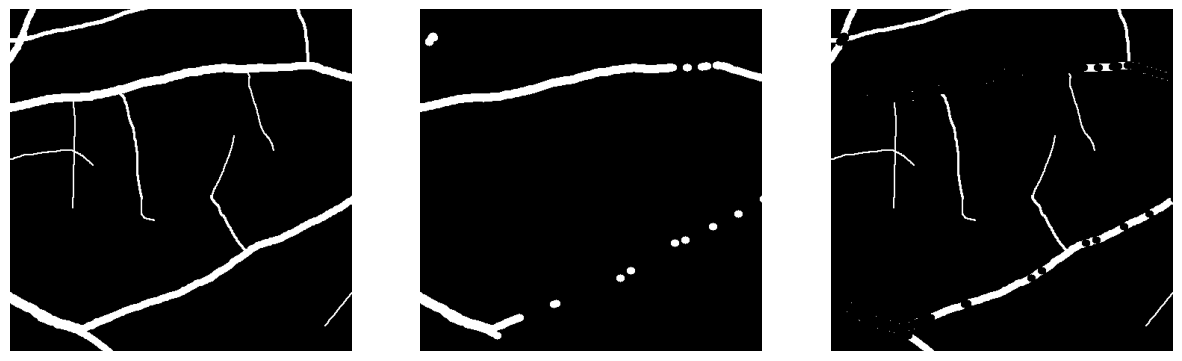

In [274]:
rint = np.random.randint(0, len(gtruth))
imshow_unravel([gtruth[rint].sum(dim=0), *gtruth[rint]])

In [275]:
# lets check if padding is right
gtruth.shape

torch.Size([450, 2, 458, 458])

In [276]:
# lets define custom dataset
class ImageDataset(Dataset):
    def __init__(self, images, targets):
        self.images  = images
        self.targets = targets

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx].float(), self.targets[idx].float()

In [277]:
dataset = ImageDataset(imgs_torch, gtruth)

------------------------------

In [278]:
# define training hyperparameters
INIT_LR = 1#1e-2
BATCH_SIZE = 15
# define the train and val splits
TRAIN_SPLIT = 0.70
VAL_SPLIT   = (1 - TRAIN_SPLIT)/2
TEST_SPLIT  = (1 - TRAIN_SPLIT)/2
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [279]:
numTrainSamples = int(len(dataset) * TRAIN_SPLIT)
numValSamples   = int(len(dataset) * VAL_SPLIT  )
numTestSamples  = len(dataset) - numTrainSamples - numValSamples
(trainData, valData, testData) = random_split(dataset,
									          [numTrainSamples, numValSamples, numTestSamples],
									          generator=torch.Generator().manual_seed(0))

In [280]:
# initialize the train, validation, and test data loaders
trainDataLoader = DataLoader(trainData, shuffle=True, batch_size=BATCH_SIZE)
valDataLoader   = DataLoader(valData,   batch_size=BATCH_SIZE)
testDataLoader  = DataLoader(testData,  batch_size=BATCH_SIZE)

# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps   = len(valDataLoader.dataset)   // BATCH_SIZE

In [281]:
def BalancedAccuracy(pred, y):
    TP = (y*pred.abs()).sum()
    FN = (y*(1-pred).abs()).sum()
    FP = ((1-y)*pred.abs()).sum()
    TN = ((1-y)*(1-pred).abs()).sum()
    sens = (TP + 0.01) / (TP + FN + 0.01)
    spec = (TN + 0.01) / (TN + FP + 0.01)
    return (sens + spec) / 2

In [282]:
x = torch.Tensor([1, 0, 1, 1, 0])
y = torch.Tensor([1, 0, 0, 0, 0])
BalancedAccuracy(x, y)

tensor(0.7506)

In [283]:
def BA_groups(pred, y):
    channel_BA = list()
    for i in range(pred.shape[1]):
        channel_BA.append(
            BalancedAccuracy(pred[:, i, :, :], y[:, i, :, :])
        )
    return sum(channel_BA)/pred.shape[1]

In [284]:
# initialize our optimizer and loss function
opt = torch.optim.SGD(model.parameters(), lr=INIT_LR) #INIT_LR

#lossFn = torch.nn.MSELoss()
lossFn = lambda x, y : 1-BA_groups(x, y)

In [285]:
# initialize a dictionary to store training history
H = {
	"train_loss": [],
	"val_loss": [],
}

In [288]:
print("[INFO] training the network...")

EPOCHS = 350

model.to(device)
#lossFn.to(device)
progress_bar = tqdm(range(0, EPOCHS))
# loop over our epochs
for e in progress_bar:
	# set the model in training mode
	model.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalValLoss = 0
	# initialize the number of correct predictions in the training
	# and validation step
	# loop over the training set
	for (x, y) in trainDataLoader:
		# send the input to the device
		(x, y) = (x.to(device), y.to(device))
		# perform a forward pass and calculate the training loss
		pred = model(x)
		loss = lossFn(pred, y)
		# zero out the gradients, perform the backpropagation step,
		# and update the weights
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
	
	# switch off autograd for evaluation
	with torch.no_grad():
		# set the model in evaluation mode
		model.eval()
		# loop over the validation set
		for (x, y) in valDataLoader:
			# send the input to the device
			(x, y) = (x.to(device), y.to(device))
			# make the predictions and calculate the validation loss
			pred = model(x)
			totalValLoss += lossFn(pred, y)

	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgValLoss   = totalValLoss / valSteps
	# update training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["val_loss"].append(avgValLoss.cpu().detach().numpy())
	# print the model training and validation information
	progress_bar.set_description(f"Train loss: {avgTrainLoss:.6f} | Val loss: {avgValLoss:.6f}")

[INFO] training the network...


  0%|          | 0/350 [00:00<?, ?it/s]

In [29]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'H': H 
            }, "model_2.pkl")

In [ ]:
state = torch.load("model_2.pkl")
model.load_state_dict(state['model_state_dict'])
opt.load_state_dict(state['optimizer_state_dict'])
H = state['H']

In [286]:
def imshow(img_bgr, ax=plt, **kw):
    nax = len(img_bgr.shape)
    if nax == 3:
      img_bgr = np.flip(img_bgr, axis=nax-1)
    ax.imshow(img_bgr, **kw)

53
torch.Size([1, 2, 458, 458])
tensor(0.5006)


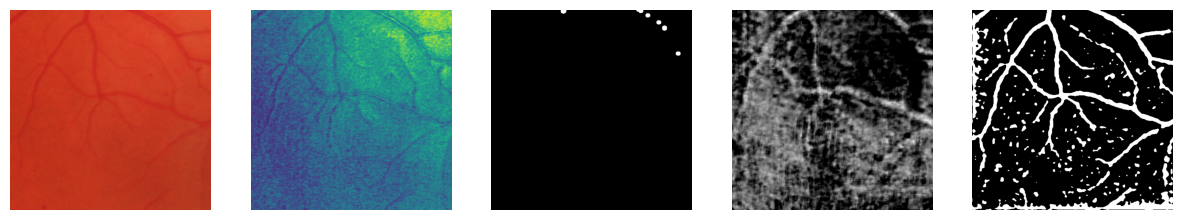

In [287]:
def wrapper():
    plt.rcParams['figure.figsize'] = [15, 5]

    model.to(device)
    f, axarr = plt.subplots(1,5)
    for a in axarr:
        a.axis("off")

    rint = np.random.randint(0, len(images))
    #rint = 432
    with torch.no_grad():
        model.eval()
        pred = model(imgs_torch[rint].float().to(device)[None, :, :, :]).cpu().detach()
    c = 0
    imshow(images[rint], axarr[0])
    imshow(imgs_torch[rint][0], axarr[1])
    imshow(gtruth[rint][c], axarr[2], cmap=plt.cm.grey)
    imshow(pred[0][c], axarr[3], cmap=plt.cm.grey)

    img_g = cv.cvtColor(images[rint], cv.COLOR_BGR2GRAY)
    labeler = alg.PSTLabeler()
    labeler.set_params(alg.PSTParameters(*params[rint]))
    lb_res = torch.Tensor(labeler.apply(img_g).edges)

    imshow(lb_res, axarr[4], cmap=plt.cm.grey)
    print(rint)
    print(pred.shape)
    print(BA_groups(pred, gtruth[rint:(rint+1)]))
    #print(BA_groups(lb_res[PAD:-PAD,PAD:-PAD], gtruth[rint]))

wrapper()

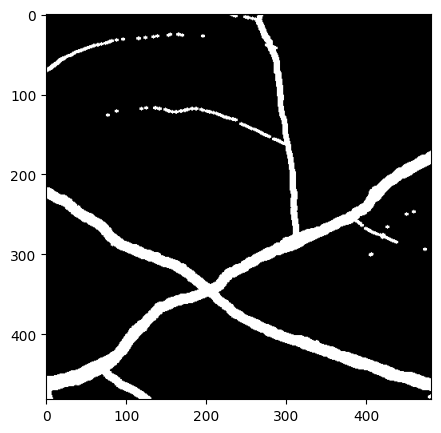

In [162]:
kernel  = cv.getStructuringElement(cv.MORPH_ELLIPSE,(5,5))
mask = (gtruth[90][0].numpy()*255).astype(np.uint8)
mask2 = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel)
details = mask-mask2
imshow(mask2, cmap=plt.cm.grey)

In [93]:
def wrapper():
    image = cv.imread("../examples/resources/example.jpg")
    halfs = (np.array(image.shape)/5).astype(int)
    #image = image[halfs[0]:-halfs[0], halfs[1]:-halfs[1], :]
    p = params[0].copy()
    p[2] = 1

    labeler.set_params(alg.PSTParameters(*p, morph_flag=False))
    l0 = torch.Tensor(np.atleast_3d(labeler.apply(image[:,:,0], flag_raw=True).edges)).permute(2,0,1)
    l1 = torch.Tensor(np.atleast_3d(labeler.apply(image[:,:,1], flag_raw=True).edges)).permute(2,0,1)
    l2 = torch.Tensor(np.atleast_3d(labeler.apply(image[:,:,2], flag_raw=True).edges)).permute(2,0,1)
    inp = torch.cat([l0, l1, l2]*3, axis=0)
    with torch.no_grad():
        model.eval()
        pred = model(inp.float().to(device)[None, :, :, :]).cpu().detach()
    imshow(pred[0][0], cmap=plt.cm.grey)
    return pred

pred = wrapper()

/home/nzuri/Projects/TP-OptiLabel/auto_labeling/auto_labeling/guided/pst_labeling.py:57: UserWarning: thresh_min or thresh_max has no effect since morph_flag is not True.
  warn("thresh_min or thresh_max has no effect since morph_flag is not True.")


AttributeError: 'Tensor' object has no attribute 'copy'

In [53]:
cv.imwrite("output.png", 255*pred[0][0].cpu().numpy())

True

In [66]:
image = cv.imread("../examples/resources/example.jpg")
labeler.apply(torch.tensor(image).permute(2,0,1), flag_raw=True).edges

TypeError: expected np.ndarray (got Tensor)

In [76]:
labeler._PST.img = torch.tensor(image).permute(2,0,1)[0:,:,:]
labeler._PST.apply_kernel(0.03, thresh_min=None, thresh_max=None, morph_flag=False)

RuntimeError: The size of tensor a (3504) must match the size of tensor b (2336) at non-singleton dimension 2

In [73]:
image.shape

(2336, 3504, 3)